## Profile at specified location

This notebooks compares the simulated profiles of variable `var` in a monthly GOTM simulation among different schemes at a given location (lon, lat).
It was used to take a closer look at the details in the simulations once a location of interest is identified in the map.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import num2date
sys.path.append(os.environ['GOTMWORK_ROOT']+'/tools', )
from gotmanalysis import GOTMOutputDataSet
%matplotlib inline

In [2]:
casename = 'JRA55-do_Global_dampV5d'
casename_short = 'JRA55-do'
timetag = '20090101-20090131'
slon = '194'
slat = '2'
# variable
var = 'temp'
# Max depth
depth = -150

In [3]:
# list of turbulent methods
turbmethod_list = ['KPP-CVMix',
                   'KPP-ROMS',
                   'KPPLT-EFACTOR',
                   'KPPLT-ENTR',
                   'KPPLT-RWHGK',
                   'EPBL',
                   'EPBL-LT',
                   'SMC',
                   'SMCLT',
                   'K-EPSILON-SG',
                   'OSMOSIS']
legend_list = ['KPP-CVMix',
               'KPP-ROMS',
               'KPPLT-VR12',
               'KPPLT-LF17',
               'KPPLT-RWHGK16',
               'ePBL',
               'ePBL-LT',
               'SMC-KC94',
               'SMCLT-H15',
               '$k$-$\epsilon$-SG95',
               'OSMOSIS']
nm = len(turbmethod_list)
# list of location
irow_2col = [1, 2, 0, 1, 2, 3, 3, 4, 4, 5, 5]
icol_2col = [0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1]
labels_2col = ['(b)', '(c)', '(g)', '(h)', '(i)', '(d)', '(j)', '(e)', '(k)','(f)','(l)']

In [4]:
# paths of files 
s1data_root = os.environ['GOTMRUN_ROOT']+'/'+casename
fig_root = os.environ['GOTMFIG_ROOT']+'/'+casename
paths = [s1data_root+'/VR1m_DT600s_'+timetag+'/'+turbmethod_list[i]+
         '/'+casename_short+'_LAT'+slat+'_LON'+slon+'/gotm_out_s1.nc' for i in range(nm)]
# initialize dataset
data = GOTMOutputDataSet(paths=paths, keys=turbmethod_list)

In [5]:
# lat and lon
ilon = int(slon)
ilat = int(slat)
if ilon > 180:
    lon_d = str(360-ilon)+'$^\circ$W'
elif ilon == 180:
    lon_d = str(360-ilon)+'$^\circ$'
else:
    lon_d = str(ilon)+'$^\circ$E'
if ilat < 0:
    lat_d = str(np.abs(ilat))+'$^\circ$S'
elif ilat == 0:
    lat_d = str(np.abs(ilat))+'$^\circ$'
else:
    lat_d = str(ilat)+'$^\circ$N'

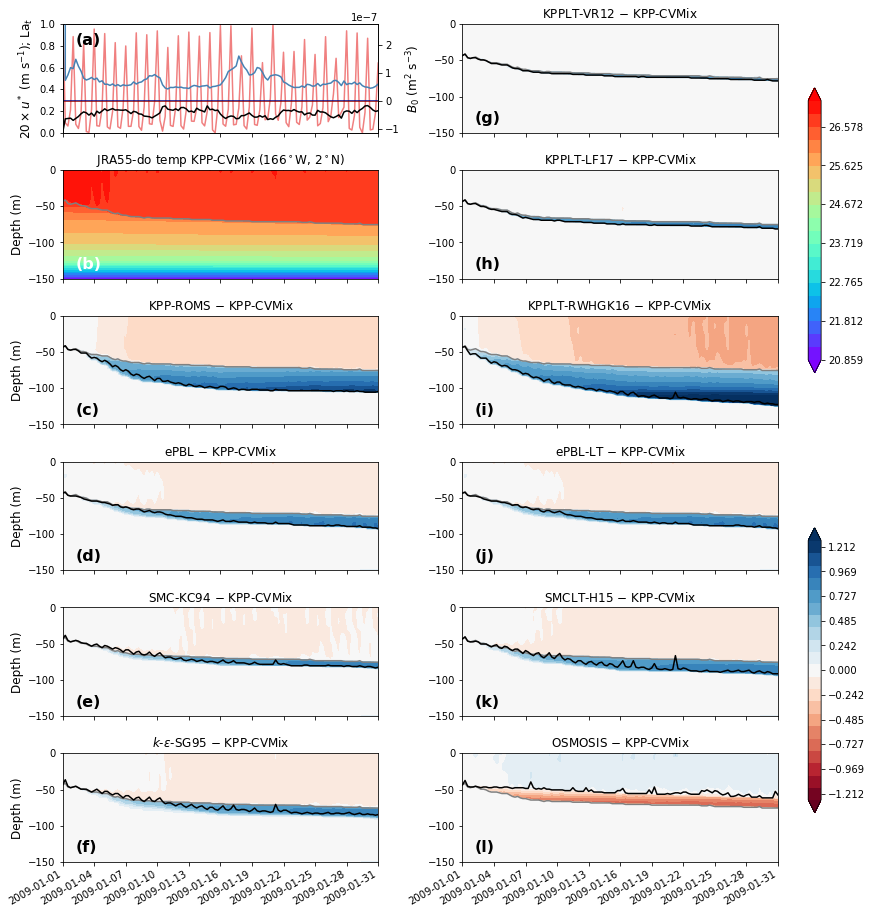

In [6]:
# figure
nrow = (nm+2)//2
fig_width = 12
fig_height = 3+2*(nrow-1)

# plot figure
height_ratios = [1]*nrow
height_ratios.append(0.15)
width_ratios = [1, 1, 0.05]
f, axarr = plt.subplots(nrow, 2, sharex='col')
f.set_size_inches(fig_width, fig_height)

# panel a
gotmdata0 = data.cases['KPP-CVMix']
dttime0 = num2date(gotmdata0.time, units=gotmdata0.time_units,
                   calendar=gotmdata0.time_calendar)
ustar0  = gotmdata0.read_timeseries('u_taus').data
laturb0 = gotmdata0.read_timeseries('La_Turb').data
hoLmo0  = gotmdata0.read_timeseries('hoLmo').data
bflux0  = gotmdata0.read_timeseries('bflux').data
par1 = axarr[0, 0].twinx()
axarr[0, 0].plot(dttime0, ustar0*20, color='black', linewidth=1.5)
axarr[0, 0].set_ylabel('$20 \\times u^*$ (m s$^{-1}$); $\mathrm{La}_t$', fontsize=12)
axarr[0, 0].set_ylim([0, 1])
axarr[0, 0].plot(dttime0, laturb0, color='steelblue', linewidth=1.5)
axarr[0, 0].axhline(0.3, color='navy', linewidth=0.75)
par1.plot(dttime0, bflux0, color='lightcoral', linewidth=1.5)
par1.set_ylabel('$B_0$ (m$^2$ s$^{-3}$)', fontsize=12)
ymax = np.percentile(bflux0, 99)
ymin = np.percentile(bflux0, 1)
par1.set_ylim([ymin, ymax])
par1.axhline(0, color='darkred', linewidth=0.75)
axarr[0, 0].set_zorder(par1.get_zorder()+1)
axarr[0, 0].patch.set_visible(False)
axarr[0, 0].text(0.04, 0.92, '(a)', transform=axarr[0, 0].transAxes,
                 fontsize=16, fontweight='bold', va='top')

# panel b
n = icol_2col[0]
m = irow_2col[0]
# get var
prfl = gotmdata0.read_profile(var)
fld0 = prfl.data
z0 = prfl.z

# contour levels
zidx = np.argmin(np.abs(z0-depth))
c_max = np.max(fld0[:,zidx:])
c_min = np.min(fld0[:,zidx:])
c_int = (c_max-c_min)/20
levels0 = np.arange(c_min, c_max+c_int, c_int)
    
# get mld
mld0 = gotmdata0.read_timeseries('mld_deltaR').data
im0 = axarr[m, n].contourf(dttime0, z0, np.transpose(fld0), levels=levels0,
                           extend='both', cmap='rainbow')
axarr[m, n].set_ylabel('Depth (m)', fontsize=12)
axarr[m, n].set_ylim([depth, 0]) 
title0 = casename_short+' '+var+' '+turbmethod_list[0]+' ('+lon_d+', '+lat_d+')'
axarr[m, n].set_title(title0, fontsize=12)
axarr[m, n].plot(dttime0, -mld0, color='gray', linewidth=1.5)
axarr[m, n].text(0.04, 0.2, labels_2col[0], transform=axarr[m, n].transAxes,
                 color='white', fontsize=16, fontweight='bold', va='top')

# panel c-l
# loop over other turbmethods
cmap = plt.cm.get_cmap('RdBu', 61)
for i in np.arange(nm-1):
    j = i+1 
    n = icol_2col[j]
    m = irow_2col[j]
    gotmdata1 = data.cases[turbmethod_list[j]]
    dttime1 = num2date(gotmdata1.time, units=gotmdata1.time_units,
                       calendar=gotmdata1.time_calendar)
    # get var
    prfl = gotmdata1.read_profile(var)
    fld1 = prfl.data
    z1 = prfl.z
    # contour levels
    if i == 0:
        d_max = np.max(abs(fld1[:,zidx:]-fld0[:,zidx:]))
        d_int = d_max/10
        levels1 = np.arange(-d_max-0.5*d_int, d_max+d_int, d_int)
        cb_ticks = np.arange(-d_max, d_max+d_int*2, d_int*2)
    # get mld
    mld1 = gotmdata1.read_timeseries('mld_deltaR').data
    im1 = axarr[m, n].contourf(dttime1, z1, np.transpose(fld1-fld0),
                               levels=levels1, extend='both', cmap=cmap)
    if n == 0:
        axarr[m, n].set_ylabel('Depth (m)', fontsize=12)
    axarr[m, n].set_ylim([depth, 0]) 
    title1 = legend_list[j]+' $-$ '+legend_list[0]
    axarr[m, n].set_title(title1, fontsize=12)
    axarr[m, n].plot(dttime0, -mld0, color='gray', linewidth=1.5)
    axarr[m, n].plot(dttime0, -mld1, color='black', linewidth=1.5)
    axarr[m, n].text(0.04, 0.2, labels_2col[j], transform=axarr[m, n].transAxes,
                     fontsize=16, fontweight='bold', va='top')

 # reduce margin
plt.tight_layout()

# auto adjust the x-axis label
plt.gcf().autofmt_xdate()

plt.subplots_adjust(bottom=0.075, right=0.9)
cax0 = plt.axes([0.85, 0.55, 0.1, 0.4])
cax0.set_visible(False)
cb0 = plt.colorbar(im0, ax=cax0)
cb0.formatter.set_powerlimits((-2, 2))
cb0.update_ticks()
cax1 = plt.axes([0.85, 0.08, 0.1, 0.4])
cax1.set_visible(False)
cb1 = plt.colorbar(im1, ax=cax1, ticks=cb_ticks)
cb1.formatter.set_powerlimits((-2, 2)) 
cb1.update_ticks()

# save figure
# plt.savefig(figname, dpi = 300)

# # close figure
# plt.close()